# DWD Weather Station Data
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/

In [1]:
import os
import re
import yaml
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
from itertools import combinations
from shapely.geometry import Point

<b>Weather Stations in Germany for:</b></br></br>
relative humidity (%)</br>
air pressure at station level (hPa)</br>
air temperature near ground (°C)</br>
air temperature at 2 m (°C)</br>
dew point temperature (°C)</br>

diffuse radiation (J/cm<sup>2</sup>)</br>
global radiation (J/cm<sup>2</sup>)</br>
sunshine duration (hours)</br>

wind direction (degree)</br>
wind velocity (m/s)

In [2]:
def load_config(config_path):
    with open(config_path, "r") as file:
        return yaml.safe_load(file)

In [3]:
config_path = "config.yaml"
config = load_config(config_path)

directory = config['data']['dir']
target_dir = config['data']['final_data']
params = config['synth']

vars = config['scraping']['vars']
solar_dir = config['data']['solar_dir']
wind_dir = config['data']['wind_dir']
threshold = params['threshold'] # tolerance threshold for acepting share of missing values

In [4]:
to_date = '2024-11-25'
from_date = '2023-08-01'
validate_on_quality = False

column_names = [
    "Stations_id", "von_datum", "bis_datum", "Stationshoehe",
    "geoBreite", "geoLaenge", "Stationsname", "Bundesland", "Abgabe"
]

features = []
for feature in params:
    if not feature == 'threshold':
        features.append(params[feature]['param'])

# get all station files
station_files = []
for root, dirs, files in os.walk(directory):
    if ('data/Archiv' in root) | ('data/final' in root):
        continue
    for file in files:
        if 'Stationen' in file:
            station_files.append(os.path.join(root, file))

# read all station files
stations = None
for station in station_files:
    df_station = pd.read_fwf(station, 
                             encoding='latin1',
                             skiprows=2,
                             names=column_names)
    df_station['von_datum'] = pd.to_datetime(df_station['von_datum'], format='%Y%m%d')
    df_station['bis_datum'] = pd.to_datetime(df_station['bis_datum'], format='%Y%m%d')
    df_station.drop(['Abgabe'], axis=1, inplace=True)
    table_name = station.split('/')[1]
    df_station['Table'] = table_name
    if station != None:
        stations = pd.concat([stations, df_station], ignore_index=True)
    else:
        stations = df_station.copy()
stations['Stations_id'] = stations["Stations_id"].apply(lambda x: f"{x:05d}")

In [5]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Stations_id    2472 non-null   object        
 1   von_datum      2472 non-null   datetime64[ns]
 2   bis_datum      2472 non-null   datetime64[ns]
 3   Stationshoehe  2472 non-null   int64         
 4   geoBreite      2472 non-null   float64       
 5   geoLaenge      2472 non-null   float64       
 6   Stationsname   2472 non-null   object        
 7   Bundesland     2472 non-null   object        
 8   Table          2472 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 173.9+ KB


In [6]:
for root, dirs, files in os.walk(directory):
    if ('data/Archiv' in root) | ('data/final' in root):
        continue
    print(f'In {root} are {len(files)} files.')

print('')
print(stations.groupby('Table').size().sort_index(ascending=False))

print('\n It is likely that data is not available for all stations.')

In data are 0 files.
In data/precipitation are 1357 files.
In data/Marktstammdatenregister are 325 files.
In data/air_temperature are 477 files.
In data/wind_test are 274 files.
In data/solar are 245 files.

Table
wind_test           273
solar               325
precipitation      1354
air_temperature     520
dtype: int64

 It is likely that data is not available for all stations.


In [7]:
stations.drop(stations[stations.bis_datum < to_date].index, inplace=True)
stations.drop(stations[stations.von_datum > from_date].index, inplace=True)

counts = stations.groupby(['Stations_id']).size().value_counts().sort_index()
table_counts = stations.groupby(['Stations_id', 'Table']).size()

print(f'{len(stations.Stations_id.unique())} unique weather stations \n')

for e, c in enumerate(counts, start=1):
    print(f'{c} stations with values in {e} tables.')

print('\nAbsolute number of stations for:')
stations.groupby('Table').size()

1347 unique weather stations 

884 stations with values in 1 tables.
236 stations with values in 2 tables.
107 stations with values in 3 tables.
120 stations with values in 4 tables.

Absolute number of stations for:


Table
air_temperature     464
precipitation      1280
solar               146
wind_test           267
dtype: int64

In [8]:
stations

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,Table
0,00020,2004-08-12,2025-01-23,432,48.9219,9.9129,Abtsgmünd-Untergröningen,Baden-Württemberg,precipitation
1,00029,2002-08-28,2025-01-24,260,49.7175,10.9101,Adelsdorf (Kläranlage),Bayern,precipitation
2,00044,2007-02-08,2025-01-24,44,52.9336,8.2370,Großenkneten,Niedersachsen,precipitation
3,00046,2002-09-24,2025-01-24,325,48.9450,12.4639,Aholfing,Bayern,precipitation
4,00053,2005-08-31,2025-01-23,60,52.5850,13.5634,Ahrensfelde,Brandenburg,precipitation
...,...,...,...,...,...,...,...,...,...
2461,07420,2007-05-14,2025-01-24,246,51.1045,11.7113,Naumburg/Saale-Kreipitzsch,Sachsen-Anhalt,solar
2467,13965,2008-10-30,2025-01-24,619,48.2639,8.8134,Balingen-Bronnhaupten,Baden-Württemberg,solar
2468,15000,2011-03-11,2025-01-24,231,50.7983,6.0244,Aachen-Orsbach,Nordrhein-Westfalen,solar
2469,15207,2013-11-01,2025-01-24,317,51.2835,9.3590,Schauenburg-Elgershausen,Hessen,solar


In [9]:
grouped = stations.groupby(['Stations_id'])['Table'].apply(list)

combination_counts = {}
for categories in grouped:
    for pair in combinations(categories, 2):
        pair = tuple(sorted(pair))
        combination_counts[pair] = combination_counts.get(pair, 0) + 1
    
grouped_counts = stations.groupby(["Stations_id", "Table"]).size().unstack(fill_value=0)
single_entries = grouped_counts[grouped_counts.sum(axis=1) == 1].sum()

matrix = pd.DataFrame(0, index=vars, columns=vars)

for (cat1, cat2), count in combination_counts.items():
    matrix.loc[cat1, cat2] += count
    matrix.loc[cat2, cat1] += count  

for category in vars:
    if category in single_entries:
        matrix.loc[category, category] = single_entries[category]
        
matrix

,air_temperature,solar,precipitation,wind_test
air_temperature,1,146,461,203
solar,146,0,144,122
precipitation,461,144,819,201
wind_test,203,122,201,64


In [10]:
valid_stations = (
    stations.groupby("Stations_id")["Table"]
    .apply(lambda x: set(x) == {"air_temperature", "solar", "wind_test", "precipitation"})
)

valid_stations_ids = valid_stations[valid_stations].index

stations3 = stations[stations["Stations_id"].isin(valid_stations_ids)]

120 unique weather stations after cleaning. 



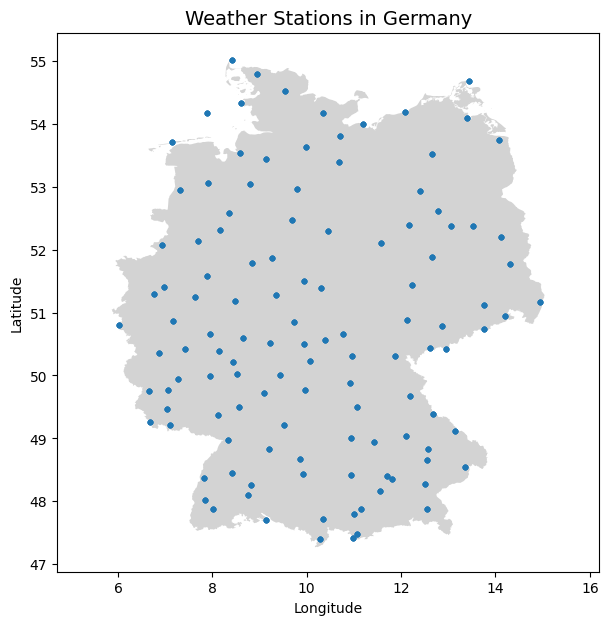

In [11]:
germany = gpd.read_file('geoBoundaries-DE.geojson')

geometry = [Point(xy) for xy in zip(stations3['geoLaenge'], stations3['geoBreite'])]
geo_df = gpd.GeoDataFrame(stations3, geometry=geometry)

print(f'{len(stations3.Stations_id.unique())} unique weather stations after cleaning. \n')

fig, ax = plt.subplots(figsize=(7, 7))
germany.plot(ax=ax, color='lightgrey')  
geo_df.plot(ax=ax, 
            label='Stations', 
            markersize=10, 
            legend=True)

stretch_factor = 0.75 
ax.set_aspect(1 / stretch_factor, adjustable='datalim')

plt.title('Weather Stations in Germany', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [12]:
stations_ids = stations3.Stations_id.unique()

# get list of relevant station files
file_paths = []
for root, dirs, files in os.walk(directory):
    if ('data/Archiv' in root) | ('data/final' in root):
        continue
    for file in files:
        if 'produkt' in file:
            file_split = re.split(r'[_\.]', file)
            
            to_date_file = datetime.strptime(file_split[5], '%Y%m%d')
            
            in_date = not to_date_file < datetime.strptime(to_date, '%Y-%m-%d')  
            in_ids = file_split[-2] in stations_ids
            
            if in_date and in_ids:
                file_paths.append(os.path.join(root, file))

In [13]:
# check if the list of files contains all relevant stations
extracted_data = []

for path in file_paths:
    parts = re.split(r'[\/_.]', path) 
    category = parts[1]
                   
    if category == "air":
        category = "air_temperature"
        date = parts[8]       
        station_id = parts[9]
    elif category == 'wind':
        category = 'wind_test'
        date = parts[8]       
        station_id = parts[9] 
    else:
        date = parts[7]       
        station_id = parts[8]
           
    extracted_data.append([category, date, station_id])

df_proof = pd.DataFrame(extracted_data, columns=["Category", "Date", "Stations_ID"])


In [14]:
df_proof.groupby('Category').size()

Category
air_temperature    120
precipitation      120
solar              120
wind_test          120
dtype: int64

In [15]:
proof = [id for id in df_proof.Stations_ID.unique() if not id in stations_ids]
        
if proof:
    print('There are inconsistent stations in your dataframe.')
else:
    print('The stations are consistent with your stations_ids list.')

The stations are consistent with your stations_ids list.


In [16]:
# group paths by stations_id

grouped = defaultdict(lambda: {"wind_test": None, "solar": None, "air_temperature": None, 'precipitation': None})

for path in file_paths:
    parts = re.split(r'[\/_.]', path)
    category = parts[1]  
    station_id = parts[-2]
    
    if category == "air":
        category = "air_temperature"
    if category == "wind":
        category = "wind_test"
    
    grouped[station_id][category] = path

structured_list = []
for station_id, paths in grouped.items():
    if all(paths[cat] for cat in ["wind_test", "precipitation", "solar", "air_temperature"]):
        structured_list.append([
            paths["air_temperature"],
            paths["wind_test"],
            paths["solar"],
            paths["precipitation"]
        ])

In [17]:
# merge dataframes by stations_ids

final_df = []
val_results = []

def make_final_frames(validate_on_quality=False):
    for ele in structured_list:
        station_df = None
        
        for file in ele:
            station_id = re.search(r'_(\d{5})\.txt$', file).group(1)
            raw = pd.read_csv(file, sep=';')
            raw['timestamp'] = pd.to_datetime(raw['MESS_DATUM'], format='%Y%m%d%H%M')
            raw.set_index('timestamp', inplace=True)
            
            if validate_on_quality:
                category = structured_list[0][0].split('/')[1]
                q1 = raw['  QN'].quantile(0.25)
                q2 = raw['  QN'].quantile(0.5)
                q3 = raw['  QN'].quantile(0.75)
                val_results.append([station_id, category, q1, q2, q3])
            raw.drop(['MESS_DATUM', '  QN', 'eor'], axis=1, inplace=True)
            raw['STATIONS_ID'] = station_id
            
            if station_df is not None:
                station_df = pd.merge(station_df, raw, how='inner', on=['timestamp', 'STATIONS_ID'])
            else:
                station_df = raw.copy()
        station_id = station_df.STATIONS_ID.iloc[0]
        cols = ['Stationshoehe', 'geoBreite', 'geoLaenge']
        col_vals = stations3[stations3.Stations_id == station_id][cols].drop_duplicates().values
        col_vals = np.tile(col_vals, (len(station_df), 1))
        station_df[cols[0]] = col_vals[:,0]
        station_df[cols[1]] = col_vals[:,1]
        station_df[cols[2]] = col_vals[:,2]
        
        final_df.append(station_df[from_date:])
    
    if validate_on_quality:
        val_df = pd.DataFrame(data=val_results, columns=['Station_ID', 'Category', 'Q1', 'Q2', 'Q3'])
        return final_df, val_df
    return final_df

In [18]:
result = make_final_frames(validate_on_quality=validate_on_quality)

if validate_on_quality:
    final_df = result[0]
    val_df = result[1]
else:
    final_df = result

Check Quality Niveau of Measurements

In [19]:
low_qn_stations = []

if validate_on_quality:
    low_qn_stations.append(val_df.loc[val_df['Q1'] != 3.0])
    low_qn_stations.append(val_df.loc[val_df['Q2'] != 3.0])
    low_qn_stations.append(val_df.loc[val_df['Q3'] != 3.0])
    
    for i, station in enumerate(low_qn_stations):
        print(f'Stations with Quality != 3 at Q{i+1}:')
        print(station['Station_ID'].unique())

Check missing values

In [20]:
missings = {}

for df in final_df:
    station_id = df.STATIONS_ID.iloc[0]
    mask = (df == -999.0) | (df == -9999.0)
    column_counts = mask.sum()
    missings[station_id] = column_counts.values

df_missing = pd.DataFrame.from_dict(missings, orient='index', columns=df.columns)
df_missing.drop(['STATIONS_ID', 'Stationshoehe', 'geoBreite', 'geoLaenge'], axis=1, inplace=True)

for col in df_missing.columns:
    if col not in features:
        df_missing.drop(col, axis=1, inplace=True)

df_missing = df_missing.loc[:, (df_missing != 0).any(axis=0)]
df_missing = df_missing.loc[(df_missing != 0).any(axis=1)]

In [21]:
df_missing.describe()

,PP_10,TT_10,RF_10,TD_10,SLA_10,SLO_10,FF_10,DD_10,DS_10,GS_10,RWS_10
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,3645.416667,369.933333,434.041667,460.366667,603.883333,603.883333,505.175000,505.008333,17682.058333,17499.516667,1025.275000
std,15626.717972,622.075757,810.181527,908.394316,784.014643,784.014643,723.350406,723.059855,31533.190619,31619.138878,7120.540178
min,0.000000,0.000000,0.000000,0.000000,10.000000,10.000000,0.000000,0.000000,2.000000,2.000000,0.000000
25%,0.000000,8.500000,8.500000,12.250000,72.500000,72.500000,35.750000,35.750000,132.750000,85.750000,8.750000
50%,52.000000,87.500000,107.000000,107.000000,327.000000,327.000000,234.000000,234.000000,837.000000,577.500000,132.000000
75%,482.500000,454.250000,568.500000,569.250000,846.500000,846.500000,635.250000,635.250000,6746.750000,5520.500000,444.750000
max,78048.000000,3279.000000,6546.000000,7629.000000,4483.000000,4483.000000,4003.000000,4003.000000,78048.000000,78048.000000,78048.000000


In all 132 stations and several columns there are missing values.

The features DS_10 (Diffuse Horizontal Irradiance) and GS_10 (Global Horizontal Irradiance) has the most missing values.

Air Pressure (PP_10) also has high missing values, but here we can impute by pvlibs pressure to altitude method.

Dataframes with the highest number of missing values are dropped.

In [22]:
analysis = {}

for df in final_df:
    ghi = df[params['ghi']['param']]
    dhi = df[params['dhi']['param']]  
    missing_ghi = ghi.isin([-9999.0, -999.0]).sum() / len(ghi) * 100
    missing_dhi = dhi.isin([-9999.0, -999.0]).sum() / len(dhi) * 100   
    missing_percentage = missing_ghi, missing_dhi  
    station_id = df['STATIONS_ID'].iloc[0]
    analysis[station_id] = missing_percentage

analysis_df = pd.DataFrame.from_dict(analysis, orient='index', columns=["GHI %", 'DHI %'])

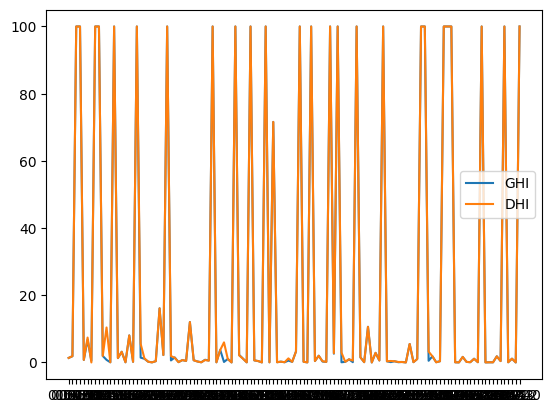

In [23]:
plt.plot(analysis_df['GHI %'], label='GHI')
plt.plot(analysis_df['DHI %'], label='DHI')

plt.legend()

In [24]:
stations_more_x_perc_missing = analysis_df.loc[(analysis_df['GHI %'] > threshold*100) | (analysis_df['DHI %'] > threshold*100)]

len(stations_more_x_perc_missing)

solar_drop_stations = stations_more_x_perc_missing.index

The same for precipiation

In [25]:
analysis = {}

for df in final_df:
    prec = df[params['prec']['param']]
    missing = prec.isin([-9999.0, -999.0]).sum() / len(prec) * 100
    station_id = df['STATIONS_ID'].iloc[0]
    analysis[station_id] = missing

analysis_df = pd.DataFrame.from_dict(analysis, orient='index', columns=["%"])

<Axes: >

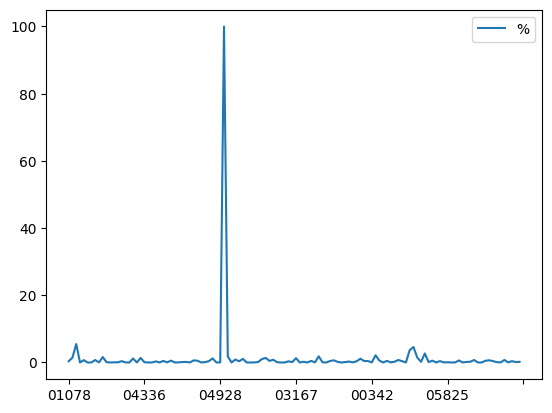

In [26]:
analysis_df.plot()

In [27]:
stations_more_x_perc_missing = analysis_df.loc[(analysis_df['%'] > 10)]
len(stations_more_x_perc_missing)
solar_drop_stations = solar_drop_stations.append(stations_more_x_perc_missing.index)

The same for pressure

In [28]:
analysis = {}

for df in final_df:
    pressure = df[params['pressure']['param']]
    missing = pressure.isin([-9999.0, -999.0]).sum() / len(pressure) * 100
    station_id = df['STATIONS_ID'].iloc[0]
    analysis[station_id] = missing

analysis_df = pd.DataFrame.from_dict(analysis, orient='index', columns=["%"])

<Axes: >

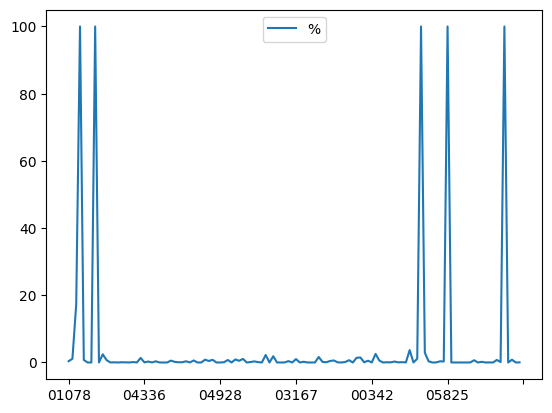

In [29]:
analysis_df.plot()#sort_values(by='%', ascending=False)

In [30]:
stations_more_x_perc_missing = analysis_df.loc[(analysis_df['%'] > 20)]

len(stations_more_x_perc_missing)

wind_drop_stations = stations_more_x_perc_missing.index

The same for wind speed

In [31]:
analysis = {}

for df in final_df:
    wind_speed = df[params['v_wind']['param']]
    missing = wind_speed.isin([-9999.0, -999.0]).sum() / len(wind_speed) * 100
    station_id = df['STATIONS_ID'].iloc[0]
    analysis[station_id] = missing

analysis_df = pd.DataFrame.from_dict(analysis, orient='index', columns=["%"])

<Axes: >

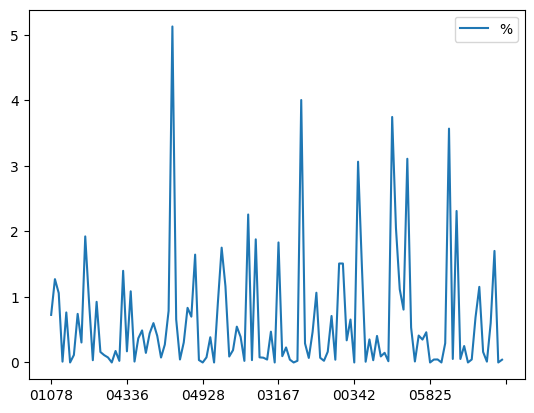

In [32]:
analysis_df.plot()#sort_values(by='%', ascending=False)

In [33]:
stations_more_x_perc_missing = analysis_df.loc[(analysis_df['%'] > threshold*100)]
len(stations_more_x_perc_missing)
wind_drop_stations = wind_drop_stations.append(stations_more_x_perc_missing.index)

In [34]:
wind_df = []
solar_df = []

dew = params['dewpoint']['param']
ghi = params['ghi']['param']
dhi = params['dhi']['param']
prec = params['prec']['param']
solar_features = [dew, ghi, dhi, prec]
sla = params['sigma_wind_lat']['param']
slo = params['sigma_wind_lon']['param']
wind_features = [sla, slo]

also_drop = ['RWS_DAU_10', 'RWS_IND_10', 'TM5_10', 'LS_10', 'SD_10']
solar_features.extend(also_drop)
wind_features.extend(also_drop)

for df in final_df:
    station_id = df['STATIONS_ID'].iloc[0]
    if not station_id in set(wind_drop_stations):
        wind_df.append(df.drop(solar_features, axis=1))
    if not station_id in set(solar_drop_stations):
        solar_df.append(df.drop(wind_features, axis=1))

In [35]:
len(solar_df), len(wind_df)

(58, 89)

Now it should be analyzed in the solar dataframes which hours has the most missing values, because the night hours can directly be imputed with zeros.

In [36]:
rad_analysis = {}

for df in solar_df:
    ghi = df[params['ghi']['param']]
    dhi = df[params['dhi']['param']]
    missing_mask = (ghi.isin([-9999.0, -999.0]) |
                    dhi.isin([-9999.0, -999.0]))
    df['hour'] = df.index.hour
    missing_hours = df.loc[missing_mask, 'hour']
    hourly_counts = missing_hours.value_counts().sort_index()
    station_id = df['STATIONS_ID'].iloc[0]
    rad_analysis[station_id] = hourly_counts
    df.drop('hour', axis=1, inplace=True)

rad_analysis_df = pd.DataFrame.from_dict(rad_analysis, orient='index').fillna(0)

In [37]:
rad_analysis_df.median().sort_index()

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
6      2.5
7      6.0
8      9.0
9     12.0
10    17.0
11    12.0
12     6.0
13     6.0
14     6.0
15     4.5
16     0.0
17     0.0
18     0.0
19     0.0
20     0.0
21     0.0
22     0.0
23     0.0
dtype: float64

The nighttime hours are less missing, indicating that sequences of missing values could be possible.

The following is an analysis of how often it occurs, that more than 1 hour in a row is missing.

In [38]:
missings = {}
missing_hours = 6 * 1

for df in solar_df:
    column_counts = {}
    station_id = df.STATIONS_ID.iloc[0]
    for column in df.columns:
        if column in ['STATIONS_ID', 'Stationshoehe', 'geoBreite', 'geoLaenge']:
            continue
        
        mask = (df[column] == -999.0) | (df[column] == -9999.0)
        sequence_lengths = mask.groupby((~mask).cumsum()).transform('sum')
        long_sequences_count = (sequence_lengths > missing_hours).astype(int).diff().fillna(0).eq(1).sum()
        column_counts[column] = long_sequences_count

    missings[station_id] = column_counts

df_missing = pd.DataFrame.from_dict(data=missings, orient='index', columns=df.columns)
df_missing.drop(['STATIONS_ID', 'Stationshoehe', 'geoBreite', 'geoLaenge'], axis=1, inplace=True)

df_missing = df_missing.loc[:, (df_missing != 0).any(axis=0)]
df_missing = df_missing.loc[(df_missing != 0).any(axis=1)]

In [39]:
df_missing.describe()

,PP_10,TT_10,RF_10,TD_10,FF_10,DD_10,DS_10,GS_10,RWS_10
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,1.068966,1.620690,1.862069,1.879310,3.172414,3.172414,3.465517,3.310345,2.896552
std,1.348971,1.936062,2.251302,2.240595,3.003728,3.003728,3.062023,2.603688,3.936735
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,0.250000
50%,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000,1.000000
75%,1.750000,2.000000,2.750000,2.750000,4.000000,4.000000,4.750000,4.000000,3.000000
max,7.000000,10.000000,12.000000,12.000000,15.000000,15.000000,15.000000,15.000000,16.000000


The same for the wind frames:

In [40]:
missings = {}
missing_hours = 6 * 1

for df in wind_df:
    column_counts = {}
    station_id = df.STATIONS_ID.iloc[0]
    for column in df.columns:
        if column in ['STATIONS_ID', 'Stationshoehe', 'geoBreite', 'geoLaenge']:
            continue
        
        mask = (df[column] == -999.0) | (df[column] == -9999.0)
        sequence_lengths = mask.groupby((~mask).cumsum()).transform('sum')
        long_sequences_count = (sequence_lengths > missing_hours).astype(int).diff().fillna(0).eq(1).sum()
        column_counts[column] = long_sequences_count

    missings[station_id] = column_counts

df_missing = pd.DataFrame.from_dict(data=missings, orient='index', columns=df.columns)
df_missing.drop(['STATIONS_ID', 'Stationshoehe', 'geoBreite', 'geoLaenge'], axis=1, inplace=True)

df_missing = df_missing.loc[:, (df_missing != 0).any(axis=0)]
df_missing = df_missing.loc[(df_missing != 0).any(axis=1)]

In [41]:
df_missing.describe()

,PP_10,TT_10,RF_10,SLA_10,SLO_10,FF_10,DD_10
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,1.095238,1.880952,2.142857,5.166667,5.166667,3.214286,3.214286
std,1.358765,2.008445,2.360023,8.011789,8.011789,2.639238,2.639238
min,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.750000,2.000000,2.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,3.500000,3.500000,3.000000,3.000000
75%,2.000000,3.000000,3.000000,5.000000,5.000000,4.000000,4.000000
max,7.000000,10.000000,12.000000,67.000000,67.000000,12.000000,12.000000


The following is an analysis of how long are the missing sequences in average per station.

In [42]:
missings = {}

for df in solar_df:
    column_counts = {}
    station_id = df.STATIONS_ID.iloc[0]
    for column in df.columns:
        if column in ['STATIONS_ID', 'Stationshoehe', 'geoBreite', 'geoLaenge']:
            continue
        
        mask = (df[column] == -999.0) | (df[column] == -9999.0)
        group_sizes = mask.groupby((~mask).cumsum()).sum()  # Gruppengrößen berechnen
        mean_length = group_sizes[group_sizes > 0].mean()  # Mittlere Länge der Sequenzen berechnen
        column_counts[column] = mean_length if not pd.isna(mean_length) else 0  # NaN durch 0 ersetzen

    missings[station_id] = column_counts

df_missing = pd.DataFrame.from_dict(missings, orient='index')

df_missing = df_missing.loc[:, (df_missing != 0).any(axis=0)]
df_missing = df_missing.loc[(df_missing != 0).any(axis=1)]

In [43]:
df_missing.describe()

,PP_10,TT_10,RF_10,TD_10,FF_10,DD_10,DS_10,GS_10,RWS_10
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,57.231527,55.076437,54.122879,51.841270,76.009086,76.009086,39.139791,37.601760,62.110256
std,109.191956,98.179132,100.989052,94.620153,116.796740,116.796740,85.212510,81.286877,107.302999
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000
25%,0.000000,0.000000,0.750000,3.125000,14.000000,14.000000,8.000000,8.000000,4.625000
50%,13.000000,20.500000,19.500000,20.166667,30.964286,30.964286,14.711111,14.100000,24.000000
75%,49.875000,48.875000,41.125000,41.250000,88.714286,88.714286,36.394444,40.937500,58.156250
max,595.000000,599.000000,599.000000,599.000000,596.000000,596.000000,596.000000,596.000000,540.000000


The same for wind:

In [44]:
missings = {}

for df in wind_df:
    column_counts = {}
    station_id = df.STATIONS_ID.iloc[0]
    for column in df.columns:
        if column in ['STATIONS_ID', 'Stationshoehe', 'geoBreite', 'geoLaenge']:
            continue
        
        mask = (df[column] == -999.0) | (df[column] == -9999.0)
        group_sizes = mask.groupby((~mask).cumsum()).sum()  # Gruppengrößen berechnen
        mean_length = group_sizes[group_sizes > 0].mean()  # Mittlere Länge der Sequenzen berechnen
        column_counts[column] = mean_length if not pd.isna(mean_length) else 0  # NaN durch 0 ersetzen

    missings[station_id] = column_counts

df_missing = pd.DataFrame.from_dict(missings, orient='index')

df_missing = df_missing.loc[:, (df_missing != 0).any(axis=0)]
df_missing = df_missing.loc[(df_missing != 0).any(axis=1)]

In [45]:
df_missing.describe()

,PP_10,TT_10,RF_10,SLA_10,SLO_10,FF_10,DD_10
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,65.028036,72.516399,83.393785,18.347277,18.347277,69.358106,69.358106
std,119.968255,123.995945,143.218000,22.474506,22.474506,115.414591,115.414591
min,0.000000,0.000000,0.000000,1.059016,1.059016,0.000000,0.000000
25%,0.000000,0.000000,0.000000,4.545455,4.545455,14.500000,14.500000
50%,15.000000,23.500000,23.000000,7.714286,7.714286,34.000000,34.000000
75%,67.000000,79.500000,106.000000,27.500000,27.500000,75.750000,75.750000
max,705.000000,705.000000,711.000000,121.500000,121.500000,711.000000,711.000000


In [68]:
for pv in solar_df:
    pv.replace({-999.0: np.nan, -9999.0: np.nan}, inplace=True)
    
for w in wind_df:
    w.replace({-999.0: np.nan, -9999.0: np.nan}, inplace=True)

In [69]:
pv_stations_list = []
wind_stations_list = []

for pv, w in zip(solar_df, wind_df):
    
    lon = params['longitude']['param']
    lat = params['latitude']['param']
    
    pv_stations_list.append([pv['STATIONS_ID'].values[0], pv[lon].values[0], pv[lat].values[0]])
    wind_stations_list.append([w['STATIONS_ID'].values[0], w[lon].values[0], w[lat].values[0]])
    
pv_stations = pd.DataFrame(data=pv_stations_list, columns=['Station_id', 'Lon', 'Lat'])
wind_stations = pd.DataFrame(data=wind_stations_list, columns=['Station_id', 'Lon', 'Lat'])

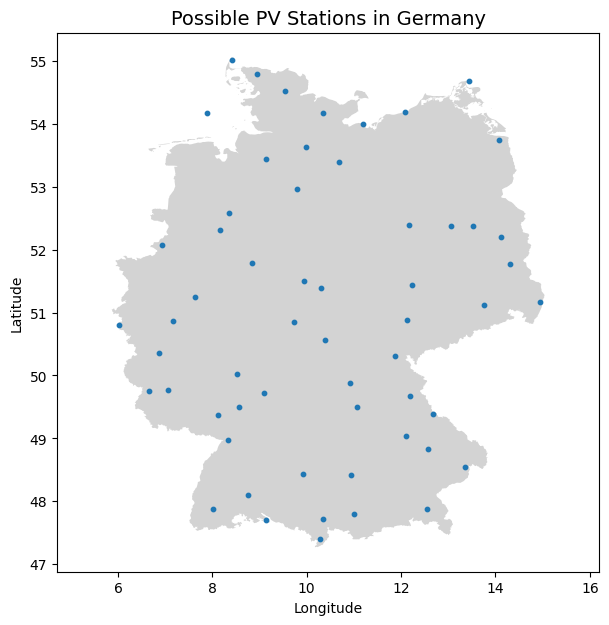

In [70]:
geometry = [Point(xy) for xy in zip(pv_stations['Lon'], pv_stations['Lat'])]
geo_df = gpd.GeoDataFrame(pv_stations, geometry=geometry)

fig, ax = plt.subplots(figsize=(7, 7))
germany.plot(ax=ax, color='lightgrey')  
geo_df.plot(ax=ax, 
            label='Stations', 
            markersize=10, 
            legend=True)

stretch_factor = 0.75 
ax.set_aspect(1 / stretch_factor, adjustable='datalim')

plt.title('Possible PV Stations in Germany', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

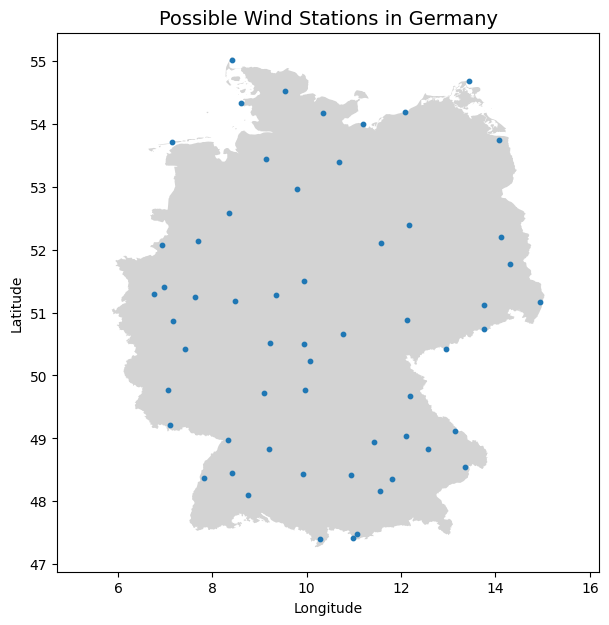

In [71]:
geometry = [Point(xy) for xy in zip(wind_stations['Lon'], wind_stations['Lat'])]
geo_df = gpd.GeoDataFrame(wind_stations, geometry=geometry)

fig, ax = plt.subplots(figsize=(7, 7))
germany.plot(ax=ax, color='lightgrey')  
geo_df.plot(ax=ax, 
            label='Stations', 
            markersize=10, 
            legend=True)

stretch_factor = 0.75 
ax.set_aspect(1 / stretch_factor, adjustable='datalim')

plt.title('Possible Wind Stations in Germany', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [72]:
print(f'{len(solar_df)} solar stations.')
print(f'{len(wind_df)} wind stations.')

58 solar stations.
89 wind stations.


In [73]:
# write csv from final dataframes

os.makedirs(target_dir, exist_ok=True)
os.makedirs(solar_dir, exist_ok=True)
os.makedirs(wind_dir, exist_ok=True)
for df in solar_df:
    file_name = f'Station_{str(df.STATIONS_ID.unique()[0])}.csv'
    dir = os.path.join(solar_dir, file_name)
    df.to_csv(dir)
    
for df in wind_df:
    file_name = f'Station_{str(df.STATIONS_ID.unique()[0])}.csv'
    dir = os.path.join(wind_dir, file_name)
    df.to_csv(dir)